In [509]:
"""
STATE: ND
POLICY: Mandatory minimum for fentanyl charges
VERSION: V1
DATA SOURCE: Recidiviz/NDDOC
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: January 2023
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

In [510]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [511]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [512]:
# PA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/PA/"

# Get the simulation tag from the model inputs config
yaml_file_path = "nd_fentanyl_mm.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [513]:
biglist = [
    "NARCOTIC EQUIP-POSSESS",
    "POSS/INGESTION OF CONTROLLED SUB.",
    "OPIUM OR DERIV-POSSESS",
    "DELIVERY OF CONTROLLED SUB. - (FREE TEXT)",
    "OPIUM OR DERIV-DELIVERY",
    "DANGEROUS DRUGS - (FREE TEXT)",
    "SYNTH NARCOTIC-POSSESS",
    "HEROIN-POSESS",
    "HEROIN-DELIVERY",
    "SYNTH NARCOTIC-SELL",
    "OPIUM OR DERIV-SELL",
    "HEROIN-SELL",
    "SYNTH NARCOTIC MFR",
]

In [514]:
list_no_poss = [
    "DELIVERY OF CONTROLLED SUB. - (FREE TEXT)",
    "OPIUM OR DERIV-DELIVERY",
    "DANGEROUS DRUGS - (FREE TEXT)",
    "HEROIN-DELIVERY",
    "SYNTH NARCOTIC-SELL",
    "OPIUM OR DERIV-SELL",
    "HEROIN-SELL",
    "SYNTH NARCOTIC MFR",
]

In [515]:
# NARCOTIC EQUIP-POSSESS                       39068
# AMPHETAMINE-POSSESS                          21794
# MARIJUANA-SELL                               11060
# MARIJUANA-POSSESS                             8747
# AMPHETAMINE-DELIVERY                          8456
# POSS/INGESTION OF CONTROLLED SUB.             5675
# OPIUM OR DERIV-POSSESS                        2939
# DELIVERY OF CONTROLLED SUB. - (FREE TEXT)     2727
# AMPHETAMINE-MFR                               2124
# COCAINE-POSSESS                               1962
# COCAINE-DELIVERY                              1902
# OPIUM OR DERIV-DELIVERY                       1549
# DANGEROUS DRUGS - (FREE TEXT)                 1426
# SYNTH NARCOTIC-POSSESS                        1397
# HEROIN-POSESS                                 1227
# AMPHETAMINE-SELL                              1137
# HEROIN-DELIVERY                               1029
# HALLUCINOGEN-POSSESS                           863
# COCAINE-SELL                                   657
# MARIJUANA-PRODUCING                            636
# SYNTH NARCOTIC-SELL                            286
# OPIUM OR DERIV-SELL                            221
# HALLUCINOGEN-DISTRIB                           173
# HEROIN-SELL                                     79
# HALLUCINOGEN-MFR                                67
# INHALATION OF VAPORS                            50
# SYNTH NARCOTIC MFR                              44
# BARBITURATE-DELIVERY                            41
# CNTRFT SCHED V                                  37
# MARIJUANA-SMUGGL                                28
# DEL DRUGS TO PEN                                22
# SYNTH NARCOTIC-SMUGGL                           18
# HALLUCINOGEN                                    14
# OPIUM OR DERIV-SMUGGL                            8
# COCAINE-SMUGGL                                   4
# Name: description, dtype: int64

In [516]:
%%bigquery ndsup
select
*
from `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
join `recidiviz-123.sessions.compartment_sessions_materialized` ses
  ON sen.person_id = ses.person_id
    AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
join `recidiviz-123.sessions.charges_preprocessed` charge
  on sen.charge_id = charge.charge_id
where sen.state_code = 'US_ND'
  and sen.sentence_type IN ('SUPERVISION')
  and sen.sentence_sub_type IN ('PROBATION','COMMUNITY_CORRECTIONS')
  and sen.description in ('DELIVERY OF CONTROLLED SUB. - (FREE TEXT)',
                  'OPIUM OR DERIV-DELIVERY',
                  'DANGEROUS DRUGS - (FREE TEXT)',
                  'HEROIN-DELIVERY',
                  'SYNTH NARCOTIC-SELL',
                  'OPIUM OR DERIV-SELL',
                  'HEROIN-SELL',
                  'SYNTH NARCOTIC MFR')
  and ses.compartment_level_1 IN ('SUPERVISION')
QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sen.effective_date ORDER BY max_sentence_length_days_calculated DESC) = 1

Downloading: 100%|██████████████████████████████████████████████████| 1980/1980 [00:01<00:00, 1315.63rows/s]


In [517]:
ndsup.uccs_description_uniform.value_counts()

Distribution, Drug Unspecified        885
Other Drug Offense                    471
Distribution of opioids               350
Distribution Heroin                   207
Possession/Use of Unspecified Drug     67
Name: uccs_description_uniform, dtype: int64

In [518]:
ndsup[ndsup.ncic_code_uniform == "3599"].description.value_counts()

DELIVERY OF CONTROLLED SUB. - (FREE TEXT)    871
DANGEROUS DRUGS - (FREE TEXT)                471
SYNTH NARCOTIC-SELL                           67
SYNTH NARCOTIC MFR                            14
Name: description, dtype: int64

In [519]:
ndsup[
    (ndsup.ncic_code_uniform == "3599") & (ndsup.description.str.contains("FREE"))
].head()

,sentences_preprocessed_id,person_id,state_code,sentence_id,external_id,sentence_type,sentence_sub_type,judicial_district,effective_date,date_imposed,completion_date,is_completion_date_inferred,status,status_raw_text,parole_eligibility_date,projected_completion_date_min,projected_completion_date_max,release_eligibility_range_percent,initial_time_served_days,life_sentence,min_sentence_length_days_calculated,max_sentence_length_days_calculated,charge_id,offense_date,is_violent,is_sex_offense,classification_type,classification_subtype,description,offense_type,ncic_code,statute,uccs_code_uniform,uccs_description_uniform,uccs_category_uniform,ncic_code_uniform,ncic_description_uniform,ncic_category_uniform,nbirs_code_uniform,nbirs_description_uniform,nbirs_category_uniform,crime_against_uniform,is_drug_uniform,is_violent_uniform,offense_completed_uniform,offense_attempted_uniform,offense_conspired_uniform,county_code,sentence_metadata,consecutive_sentence_id,session_id_imposed,session_id_closest,sentence_to_session_offset_days,person_id_1,session_id,sub_session_id_start,sub_session_id_end,dataflow_session_id_start,dataflow_session_id_end,start_date,end_date,end_date_exclusive,state_code_1,compartment_level_1,compartment_level_2,session_length_days,session_days_inferred,start_reason,start_sub_reason,end_reason,is_inferred_start_reason,is_inferred_end_reason,start_reason_original,end_reason_original,earliest_start_date,last_day_of_data,inflow_from_level_1,inflow_from_level_2,outflow_to_level_1,outflow_to_level_2,age_start,age_end,gender,prioritized_race_or_ethnicity,assessment_score_start,assessment_score_end,supervising_officer_external_id_start,supervising_officer_external_id_end,compartment_location_start,compartment_location_end,correctional_level_start,correctional_level_end,case_type_start,case_type_end,judicial_district_code_start,judicial_district_code_end,age_bucket_start,age_bucket_end,assessment_score_bucket_start,assessment_score_bucket_end,charge_id_1,external_id_1,status_1,status_raw_text_1,offense_date_1,date_charged,state_code_2,county_code_1,ncic_code_1,statute_1,description_1,attempted,classification_type_1,classification_type_raw_text,classification_subtype_1,offense_type_1,is_violent_1,is_sex_offense_1,is_drug,counts,charge_notes,charging_entity,is_controlling,judge_full_name,judge_external_id,judicial_district_code,person_id_2,is_sex_offense_uniform,uccs_description_uniform_1,offense_attempted_uniform_1,is_drug_uniform_1,is_drug_external,uccs_code_uniform_1,is_violent_external,crime_against_uniform_1,nbirs_category_uniform_1,offense_conspired_uniform_1,description_external,ncic_category_uniform_1,uccs_category_uniform_1,is_violent_uniform_1,offense_completed_uniform_1,is_sex_offense_external,ncic_code_uniform_1,nbirs_description_uniform_1,ncic_description_uniform_1,ncic_code_external,nbirs_code_uniform_1,ncic_category_external,judicial_district_1
0,18,38000000326953,US_ND,38000001448218,47071,SUPERVISION,PROBATION,EXTERNAL_UNKNOWN,2004-05-14,2004-05-14,2005-08-24,False,COMPLETED,None,None,2009-05-14,2009-05-14,NaN,NaN,False,NaN,1826.0,38000002506510,None,False,None,FELONY,EXTERNAL_UNKNOWN,DELIVERY OF CONTROLLED SUB. - (FREE TEXT),None,3599,None,3080,"Distribution, Drug Unspecified","Distribution, Drug Unspecified",3599,Dangerous Drugs (describe offense),Dangerous Drugs,35A,Drug/Narcotic,Drug/Narcotic,Society,True,False,True,False,False,None,None,NaN,5.0,5.0,0.0,38000000326953,5,13,19,5.0,5.0,2004-05-14,2005-08-23,2005-08-24,US_ND,SUPERVISION,PROBATION,467,0,None,None,REVOCATION,0,0,None,REVOCATION,1997-01-02,2023-01-26,INCARCERATION,GENERAL,PENDING_CUSTODY,PENDING_CUSTODY,25,27.0,MALE,WHITE,39.0,28.0,72,72,2|Region 2,2|Region 2,None,None,GENERAL,GENERAL,NORTHEAST,NORTHEAST,25-29,25-29,39+,24-29,38000002506510,61019,PRESENT_WITHOUT_INFO,None,None,None,US_ND,US_ND_RAMSEY,3599,None,DELIVERY OF CONTROLLED SUB. - (FREE TEXT),None,FELONY,F,None,None,False,None,None,1.0,None,None,None,"{""full_name"": ""FOUGHTY""}",None

In [520]:
ndsup[
    ndsup.uccs_description_uniform == "Possession of opioids"
].description.value_counts()

Series([], Name: description, dtype: int64)

In [521]:
ndsup[
    ndsup.uccs_description_uniform == "Distribution, Drug Unspecified"
].charge_notes.value_counts()

Series([], Name: charge_notes, dtype: int64)

In [522]:
ndsup[ndsup.description == "NARCOTIC EQUIP-POSSESS"].head()  # .statute.value_counts()

,sentences_preprocessed_id,person_id,state_code,sentence_id,external_id,sentence_type,sentence_sub_type,judicial_district,effective_date,date_imposed,completion_date,is_completion_date_inferred,status,status_raw_text,parole_eligibility_date,projected_completion_date_min,projected_completion_date_max,release_eligibility_range_percent,initial_time_served_days,life_sentence,min_sentence_length_days_calculated,max_sentence_length_days_calculated,charge_id,offense_date,is_violent,is_sex_offense,classification_type,classification_subtype,description,offense_type,ncic_code,statute,uccs_code_uniform,uccs_description_uniform,uccs_category_uniform,ncic_code_uniform,ncic_description_uniform,ncic_category_uniform,nbirs_code_uniform,nbirs_description_uniform,nbirs_category_uniform,crime_against_uniform,is_drug_uniform,is_violent_uniform,offense_completed_uniform,offense_attempted_uniform,offense_conspired_uniform,county_code,sentence_metadata,consecutive_sentence_id,session_id_imposed,session_id_closest,sentence_to_session_offset_days,person_id_1,session_id,sub_session_id_start,sub_session_id_end,dataflow_session_id_start,dataflow_session_id_end,start_date,end_date,end_date_exclusive,state_code_1,compartment_level_1,compartment_level_2,session_length_days,session_days_inferred,start_reason,start_sub_reason,end_reason,is_inferred_start_reason,is_inferred_end_reason,start_reason_original,end_reason_original,earliest_start_date,last_day_of_data,inflow_from_level_1,inflow_from_level_2,outflow_to_level_1,outflow_to_level_2,age_start,age_end,gender,prioritized_race_or_ethnicity,assessment_score_start,assessment_score_end,supervising_officer_external_id_start,supervising_officer_external_id_end,compartment_location_start,compartment_location_end,correctional_level_start,correctional_level_end,case_type_start,case_type_end,judicial_district_code_start,judicial_district_code_end,age_bucket_start,age_bucket_end,assessment_score_bucket_start,assessment_score_bucket_end,charge_id_1,external_id_1,status_1,status_raw_text_1,offense_date_1,date_charged,state_code_2,county_code_1,ncic_code_1,statute_1,description_1,attempted,classification_type_1,classification_type_raw_text,classification_subtype_1,offense_type_1,is_violent_1,is_sex_offense_1,is_drug,counts,charge_notes,charging_entity,is_controlling,judge_full_name,judge_external_id,judicial_district_code,person_id_2,is_sex_offense_uniform,uccs_description_uniform_1,offense_attempted_uniform_1,is_drug_uniform_1,is_drug_external,uccs_code_uniform_1,is_violent_external,crime_against_uniform_1,nbirs_category_uniform_1,offense_conspired_uniform_1,description_external,ncic_category_uniform_1,uccs_category_uniform_1,is_violent_uniform_1,offense_completed_uniform_1,is_sex_offense_external,ncic_code_uniform_1,nbirs_description_uniform_1,ncic_description_uniform_1,ncic_code_external,nbirs_code_uniform_1,ncic_category_external,judicial_district_1


In [523]:
ndsup["compartment"] = "probation"

In [524]:
%%bigquery ndinc
select
*,
# IFNULL(ses.end_date,projected_completion_date_min) as end_date_combined
from `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
join `recidiviz-123.sessions.compartment_sessions_materialized` ses
  ON sen.person_id = ses.person_id
    AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
join `recidiviz-123.sessions.charges_preprocessed` charge
  on sen.charge_id = charge.charge_id
where sen.state_code = 'US_ND'
  and ses.compartment_level_1 IN ('INCARCERATION')
  and REGEXP_CONTAINS(charge_notes,r'(?i)fentanyl')
#   and sen.uccs_category_uniform = 'Distribution, Drug Unspecified'
QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sen.effective_date ORDER BY max_sentence_length_days_calculated DESC) = 1

Downloading: 100%|█████████████████████████████████████████████████████| 158/158 [00:01<00:00, 124.94rows/s]


In [525]:
ndinc[ndinc.max_sentence_length_days_calculated < 365]

,sentences_preprocessed_id,person_id,state_code,sentence_id,external_id,sentence_type,sentence_sub_type,judicial_district,effective_date,date_imposed,completion_date,is_completion_date_inferred,status,status_raw_text,parole_eligibility_date,projected_completion_date_min,projected_completion_date_max,release_eligibility_range_percent,initial_time_served_days,life_sentence,min_sentence_length_days_calculated,max_sentence_length_days_calculated,charge_id,offense_date,is_violent,is_sex_offense,classification_type,classification_subtype,description,offense_type,ncic_code,statute,uccs_code_uniform,uccs_description_uniform,uccs_category_uniform,ncic_code_uniform,ncic_description_uniform,ncic_category_uniform,nbirs_code_uniform,nbirs_description_uniform,nbirs_category_uniform,crime_against_uniform,is_drug_uniform,is_violent_uniform,offense_completed_uniform,offense_attempted_uniform,offense_conspired_uniform,county_code,sentence_metadata,consecutive_sentence_id,session_id_imposed,session_id_closest,sentence_to_session_offset_days,person_id_1,session_id,sub_session_id_start,sub_session_id_end,dataflow_session_id_start,dataflow_session_id_end,start_date,end_date,end_date_exclusive,state_code_1,compartment_level_1,compartment_level_2,session_length_days,session_days_inferred,start_reason,start_sub_reason,end_reason,is_inferred_start_reason,is_inferred_end_reason,start_reason_original,end_reason_original,earliest_start_date,last_day_of_data,inflow_from_level_1,inflow_from_level_2,outflow_to_level_1,outflow_to_level_2,age_start,age_end,gender,prioritized_race_or_ethnicity,assessment_score_start,assessment_score_end,supervising_officer_external_id_start,supervising_officer_external_id_end,compartment_location_start,compartment_location_end,correctional_level_start,correctional_level_end,case_type_start,case_type_end,judicial_district_code_start,judicial_district_code_end,age_bucket_start,age_bucket_end,assessment_score_bucket_start,assessment_score_bucket_end,charge_id_1,external_id_1,status_1,status_raw_text_1,offense_date_1,date_charged,state_code_2,county_code_1,ncic_code_1,statute_1,description_1,attempted,classification_type_1,classification_type_raw_text,classification_subtype_1,offense_type_1,is_violent_1,is_sex_offense_1,is_drug,counts,charge_notes,charging_entity,is_controlling,judge_full_name,judge_external_id,judicial_district_code,person_id_2,is_sex_offense_uniform,uccs_description_uniform_1,offense_attempted_uniform_1,is_drug_uniform_1,is_drug_external,uccs_code_uniform_1,is_violent_external,crime_against_uniform_1,nbirs_category_uniform_1,offense_conspired_uniform_1,description_external,ncic_category_uniform_1,uccs_category_uniform_1,is_violent_uniform_1,offense_completed_uniform_1,is_sex_offense_external,ncic_code_uniform_1,nbirs_description_uniform_1,ncic_description_uniform_1,ncic_code_external,nbirs_code_uniform_1,ncic_category_external,judicial_district_1
33,4,38000000353637,US_ND,38000000832311,124614-2,INCARCERATION,INCARCERATION,NORTHEAST,2022-03-14,2022-03-14,None,False,PRESENT_WITHOUT_INFO,None,None,2022-08-27,2022-10-26,NaN,NaN,False,NaN,360,38000002590896,2020-09-18,False,None,FELONY,B,POSS. OF CONT. SUB. W/INTENT TO DELIVER,DRUG,None,1903107A,3080,"Distribution, Drug Unspecified","Distribution, Drug Unspecified",3599,Dangerous Drugs (describe offense),Dangerous Drugs,35A,Drug/Narcotic,Drug/Narcotic,Society,True,False,True,False,False,None,None,NaN,3.0,3,0,38000000353637,4,15,18,5,7,2022-03-23,2022-11-06,2022-11-07,US_ND,INCARCERATION,GENERAL,229,0,NEW_ADMISSION,None,CONDITIONAL_RELEASE,0,0,NEW_ADMISSION,CONDITIONAL_RELEASE,2015-10-26,2023-01-26,SUPERVISION,PROBATION,SUPERVISION,DUAL,37,37,MALE,WHITE,24.0,34.0,None,None,NDSP,GFC,None,None,None,None,NORTHEAST,NORTHEAST,30-39,30-39,24-29,30-38,38000002590896,124614-2,CONVICTED,None,2020-09-18,None,US_ND,None,None,1903107A,POSS. OF CONT. SUB. W/INTENT TO DELIVER,None,FELONY,F,B,DRUG,False,None,None,2,FENTANYL,None,True,"{""full_name"": ""AGOTNESS, KARI""}",None,NORTHE

In [526]:
ndinc.ncic_description_uniform.value_counts()

Dangerous Drugs (describe offense)                    141
Narcotic Equip - Possess                                8
Obstruct - (specify Judic, Congr, Legis, Commsn) -      5
Drugs - Adulterated                                     2
Public Order Crimes                                     1
Damage Property (describe offense)                      1
Name: ncic_description_uniform, dtype: int64

In [527]:
ndinc.max_sentence_length_days_calculated.describe()

count     158.000000
mean     1006.006329
std       704.536732
min        30.000000
25%       540.000000
50%       730.000000
75%      1398.750000
max      5844.000000
Name: max_sentence_length_days_calculated, dtype: float64

In [528]:
ndinc[ndinc.end_date.isnull()].shape

(80, 150)

In [529]:
ndinc["compartment"] = "prison"

## 

In [530]:
sessions = pd.concat([ndinc, ndsup])
sessions.shape

(2138, 151)

In [531]:
sessions["LOS"] = sessions.session_length_days.where(
    sessions.end_date.notnull(), sessions.max_sentence_length_days_calculated
)

In [532]:
# sessions['LOS2'] = (sessions.end_date_combined - sessions.start_date).dt.days

In [533]:
sessions.LOS.describe()

count    2041.000000
mean      732.373346
std       575.468747
min         1.000000
25%       341.000000
50%       671.000000
75%      1094.000000
max      6251.000000
Name: LOS, dtype: float64

In [534]:
# sessions.LOS2.describe()

In [535]:
sessions["end_date_combined"] = sessions.end_date.combine_first(
    sessions.projected_completion_date_max
)

In [536]:
sessions.loc[:, "time_step"] = convert_dates(time_converter, sessions["start_date"])

In [537]:
sessions.loc[:, "time_step_end"] = convert_dates(
    time_converter, sessions["end_date_combined"]
)

In [538]:
sessions["estimated_los_months"] = (sessions.LOS / 30.4167).round()

In [539]:
# sessions = sessions.rename(columns={
#     'compartment_level_1':'compartment'
# })

In [540]:
sessions["outflow_to"] = "liberty"

# TRANSITIONS 

In [554]:
transitions = (
    sessions[pd.to_datetime(sessions.start_date) >= datetime.datetime(2017, 1, 1)]
    .groupby(["compartment", "outflow_to", "estimated_los_months"])[["person_id"]]
    .count()
    .astype(float)
)

In [555]:
transitions["crime_type"] = "none"
transitions = transitions.reset_index().rename(
    columns={
        "person_id": "total_population",
        "estimated_los_months": "compartment_duration",
    }
)

In [556]:
transitions.head()

,compartment,outflow_to,compartment_duration,total_population,crime_type
0,prison,liberty,1.0,1.0,none
1,prison,liberty,3.0,1.0,none
2,prison,liberty,4.0,4.0,none
3,prison,liberty,5.0,7.0,none
4,prison,liberty,6.0,3.0,none


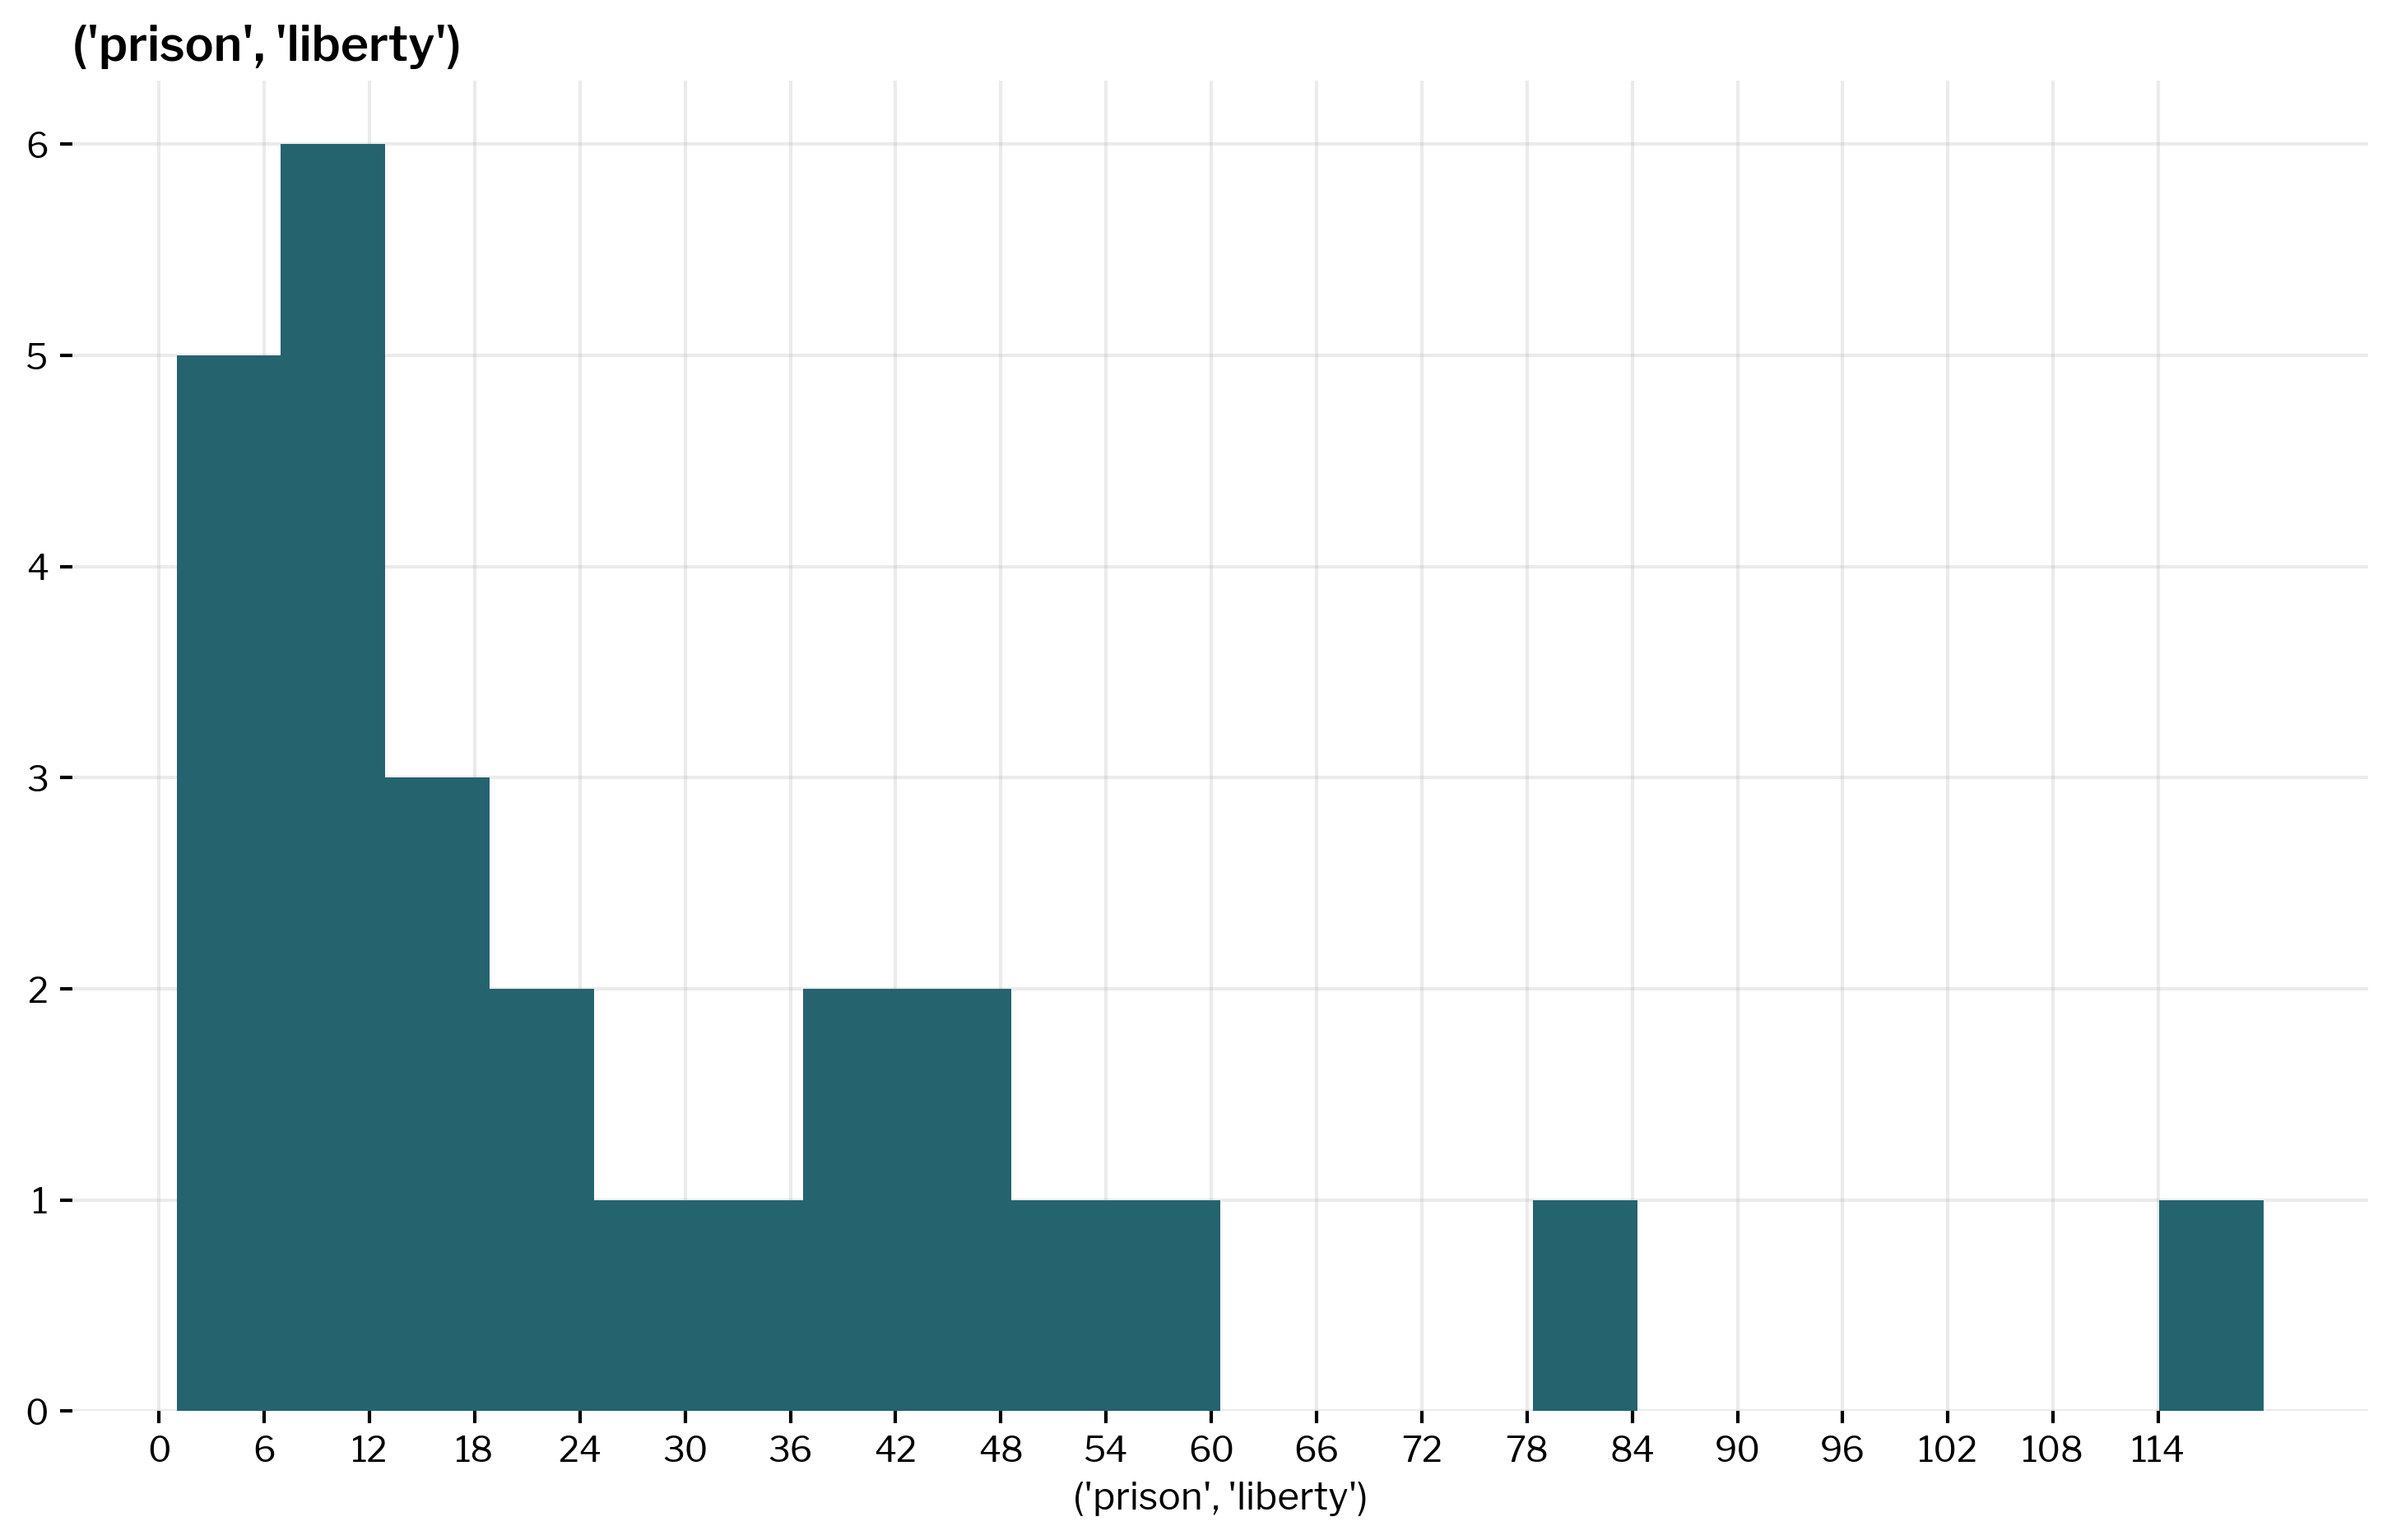

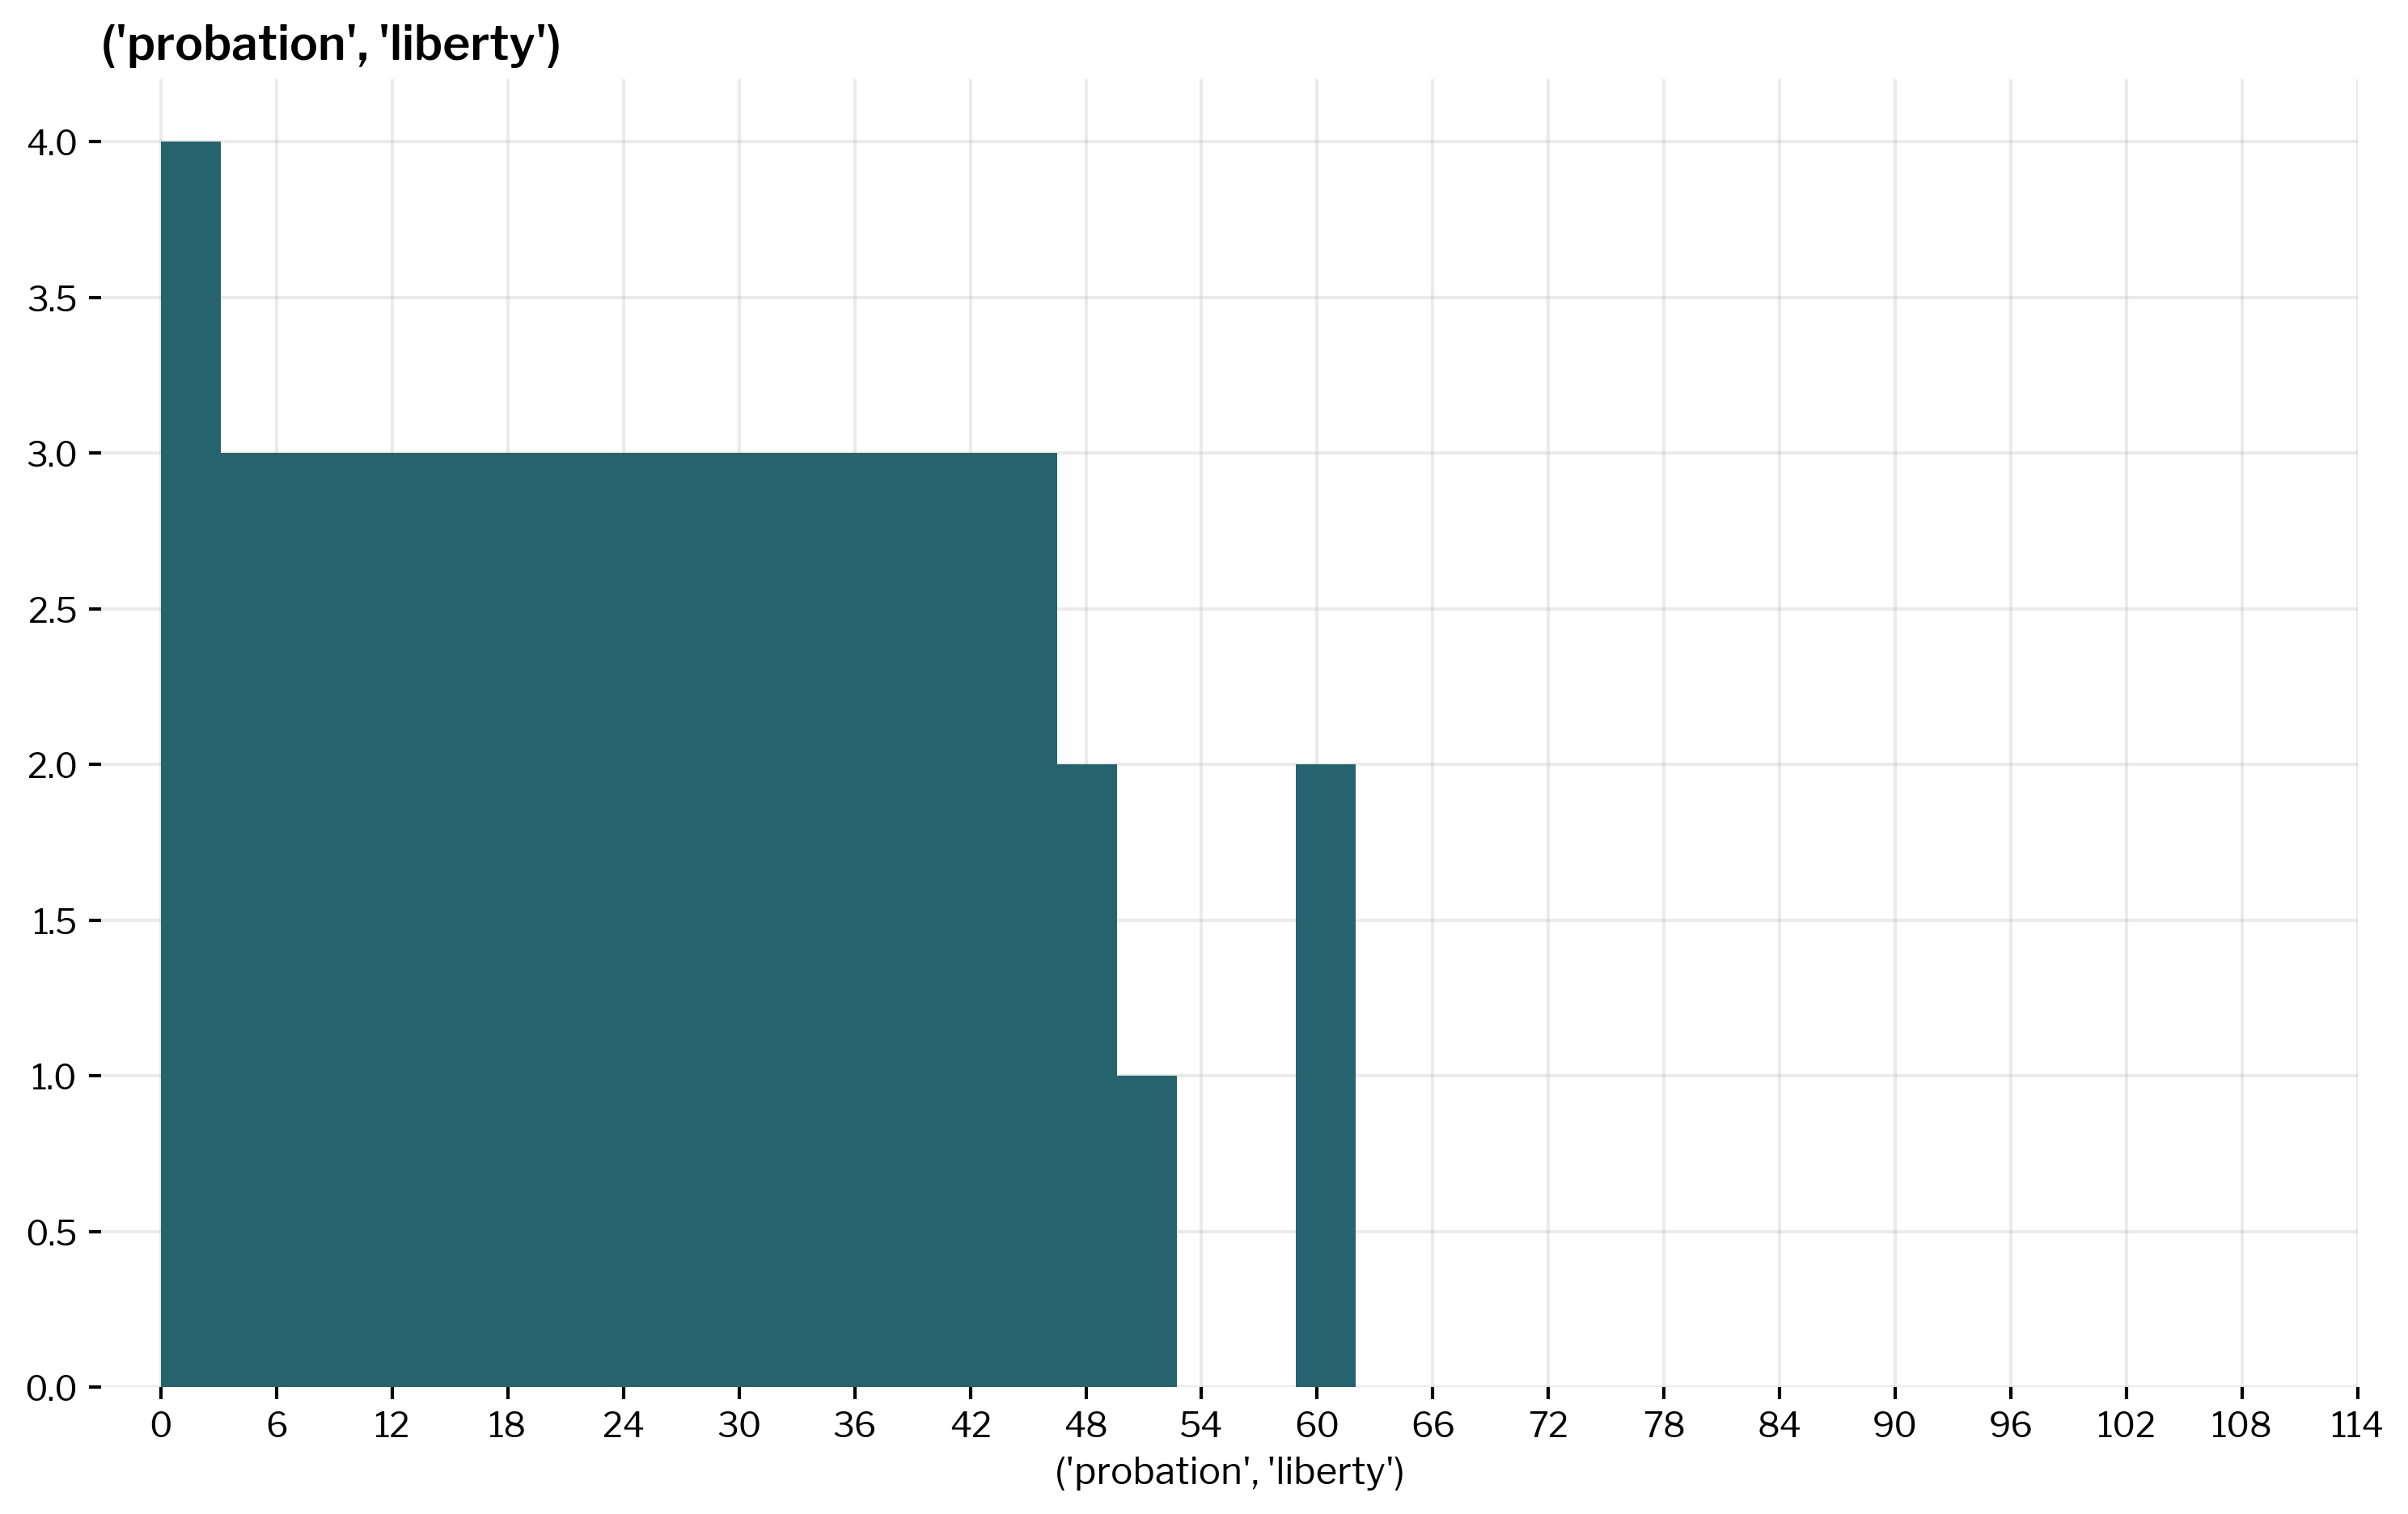

In [577]:
for group, grouped in transitions.groupby(["compartment", "outflow_to"]):
    grouped[["compartment_duration"]].hist(bins=20)
    plt.xlabel(f"{group}")
    plt.xticks(np.arange(0, 120, 6))
    plt.title(f"{group}")

# TOTAL POPULATION 

In [567]:
def get_total_population(sessions, session_start_field, session_end_field):
    total_population_start_ts = -600
    total_population = []
    for time_step in range(total_population_start_ts, 1):
        active_population = sessions[
            (sessions[session_start_field] <= time_step)
            & (time_step < sessions[session_end_field])
        ]
        active_population = (
            active_population.groupby(["compartment"])
            .person_id.count()
            .astype(float)
            .reset_index()
        )

        active_population[session_start_field] = time_step
        total_population.append(active_population)

    total_population_df = pd.concat(total_population)
    total_population_df.rename(
        columns={"person_id": "total_population"},
        inplace=True,
    )
    return total_population_df

In [568]:
total_population = get_total_population(sessions, "time_step", "time_step_end")

In [569]:
total_population.head()

,compartment,total_population,time_step
0,probation,1.0,-466
0,probation,1.0,-465
0,probation,1.0,-464
0,probation,3.0,-463
0,probation,4.0,-462


<AxesSubplot: xlabel='time_step'>

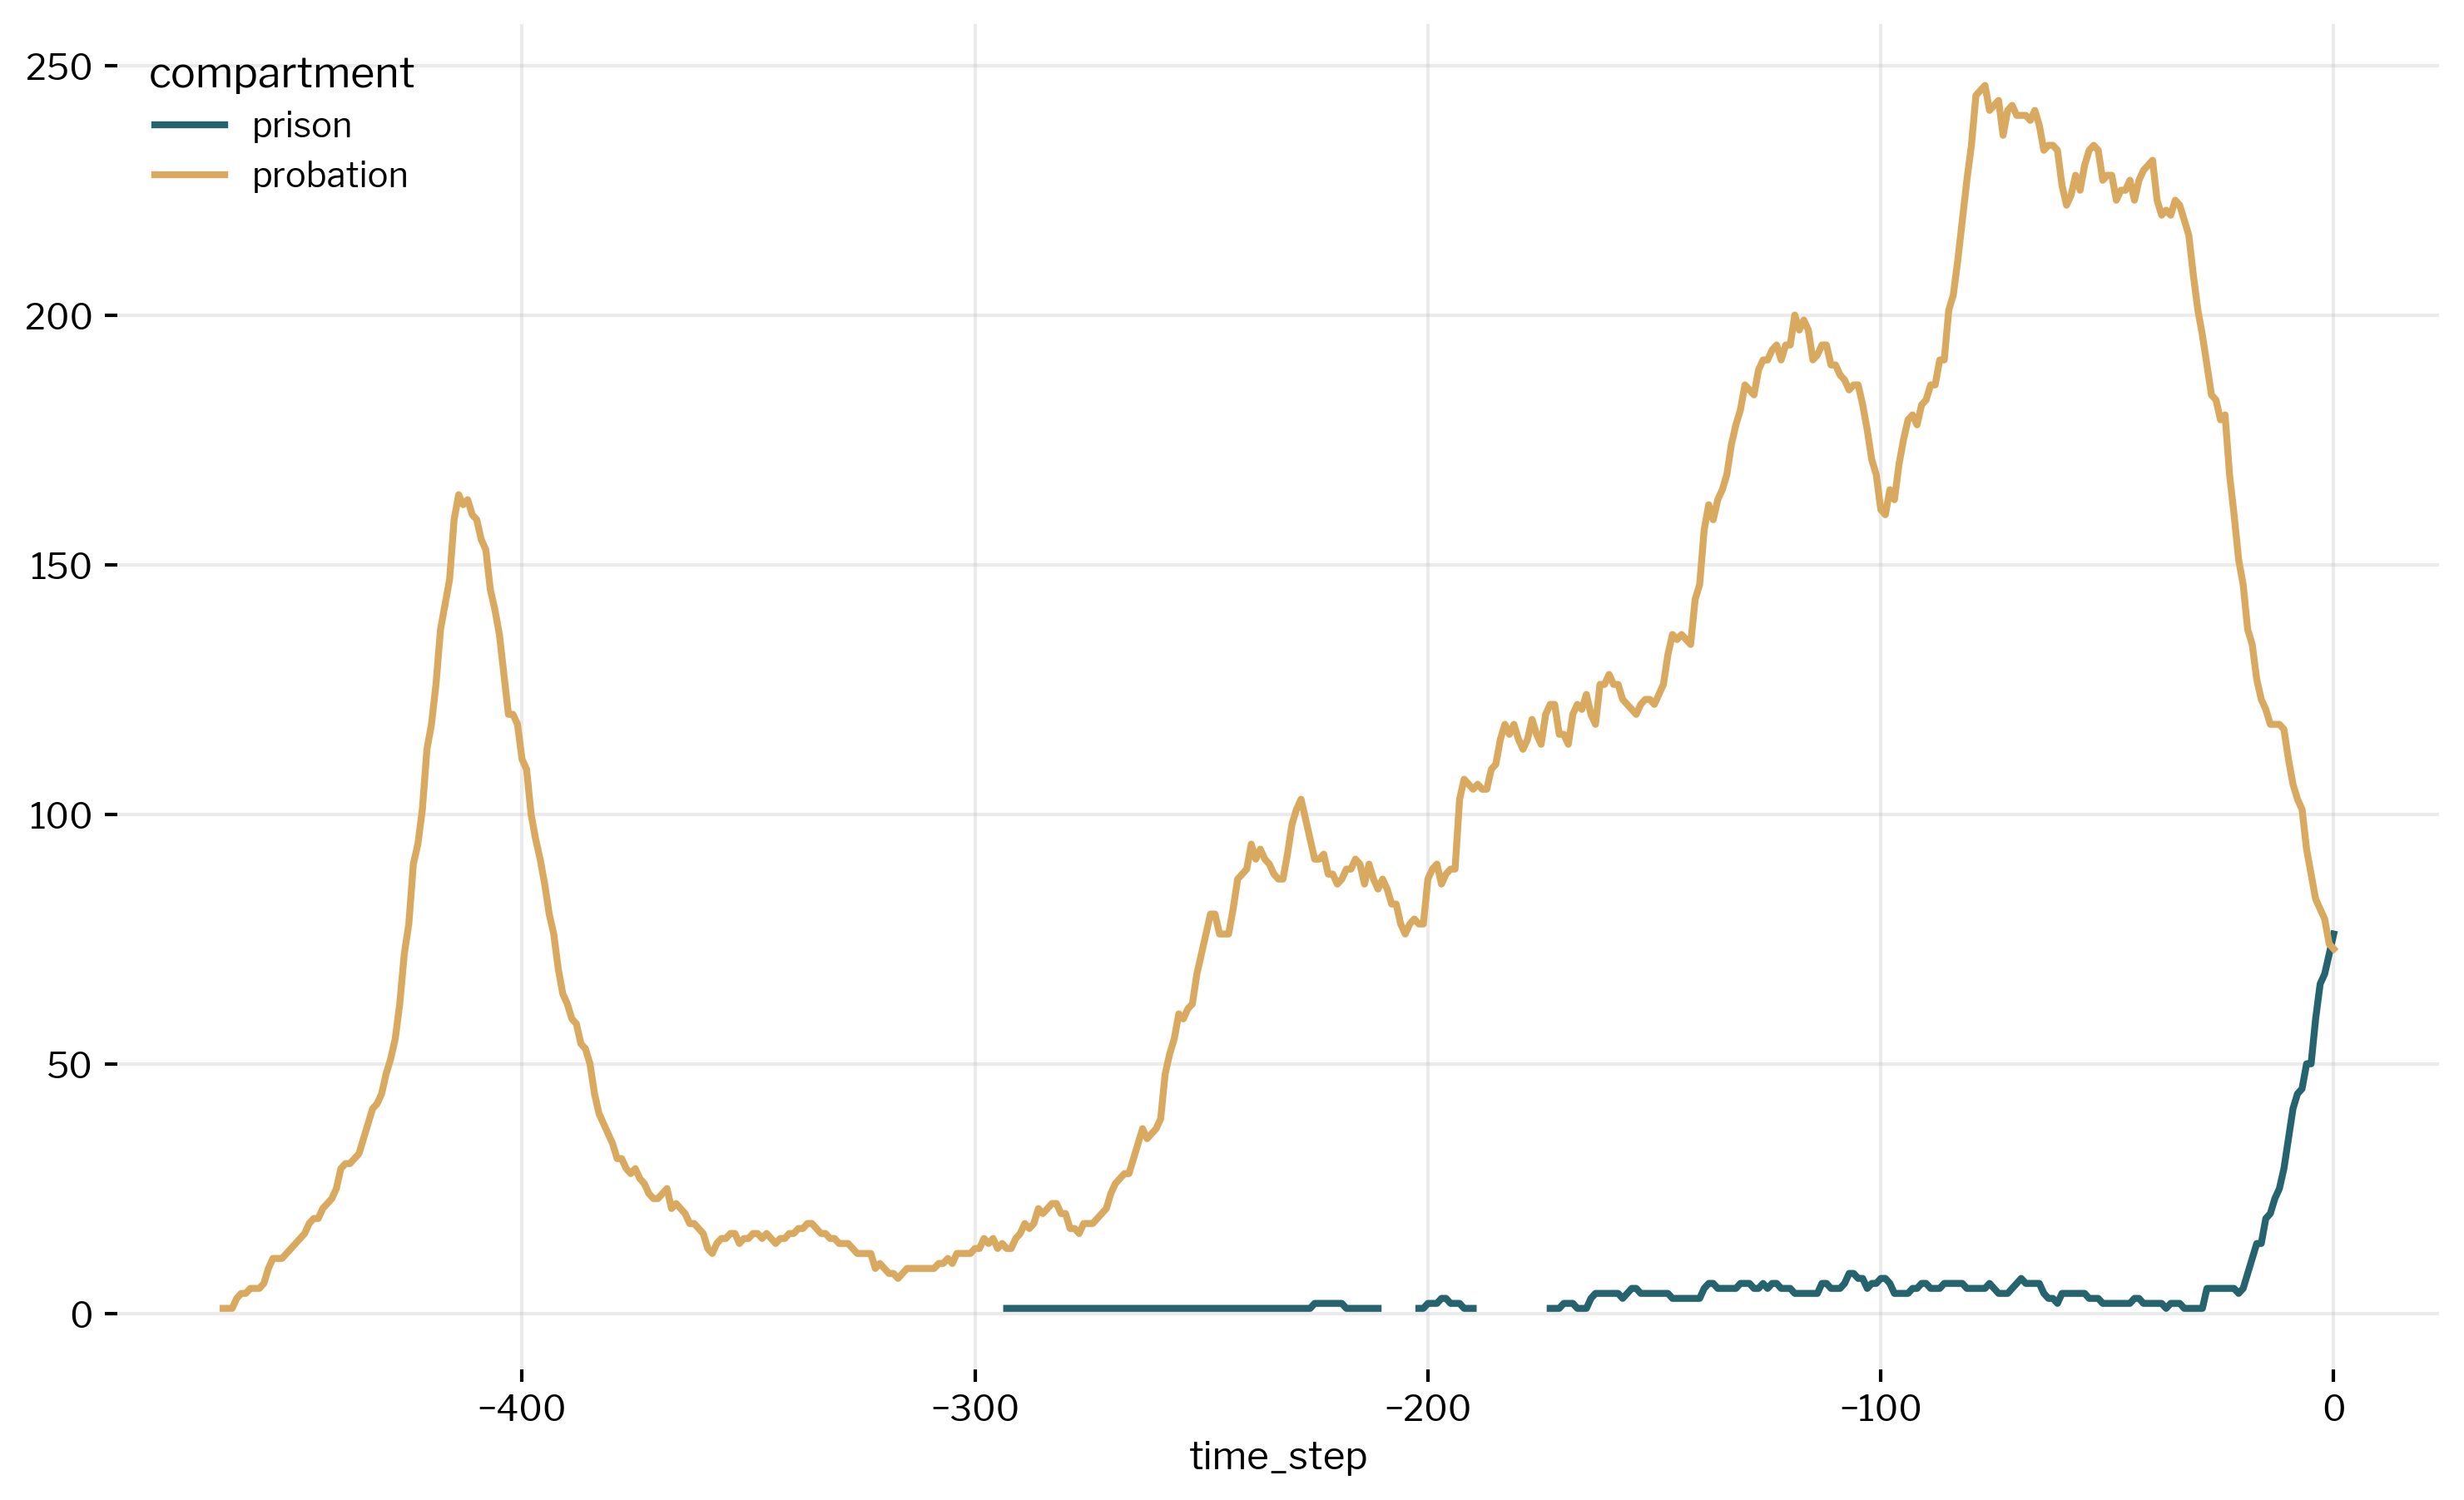

In [570]:
total_population.pivot(
    index="time_step", columns="compartment", values="total_population"
).plot()

# OUTFLOWS

In [571]:
# group by disagg and sentence start month
monthly_admissions_data = (
    sessions[sessions.time_step <= 0]
    .groupby(["compartment", "time_step"])[["person_id"]]
    .nunique()
    .astype("float64")
    .reset_index()
    .rename(columns={"person_id": "total_population", "compartment": "outflow_to"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data["crime_type"] = "none"

In [572]:
monthly_admissions_data

,outflow_to,time_step,total_population,compartment,crime_type
0,prison,-293,1.0,pretrial,none
1,prison,-225,1.0,pretrial,none
2,prison,-202,1.0,pretrial,none
3,prison,-200,1.0,pretrial,none
4,prison,-197,1.0,pretrial,none
5,prison,-173,1.0,pretrial,none
6,prison,-170,1.0,pretrial,none
7,prison,-164,1.0,pretrial,none
8,prison,-163,1.0,pretrial,none
9,prison,-162,1.0,pretrial,none


<AxesSubplot: xlabel='time_step'>

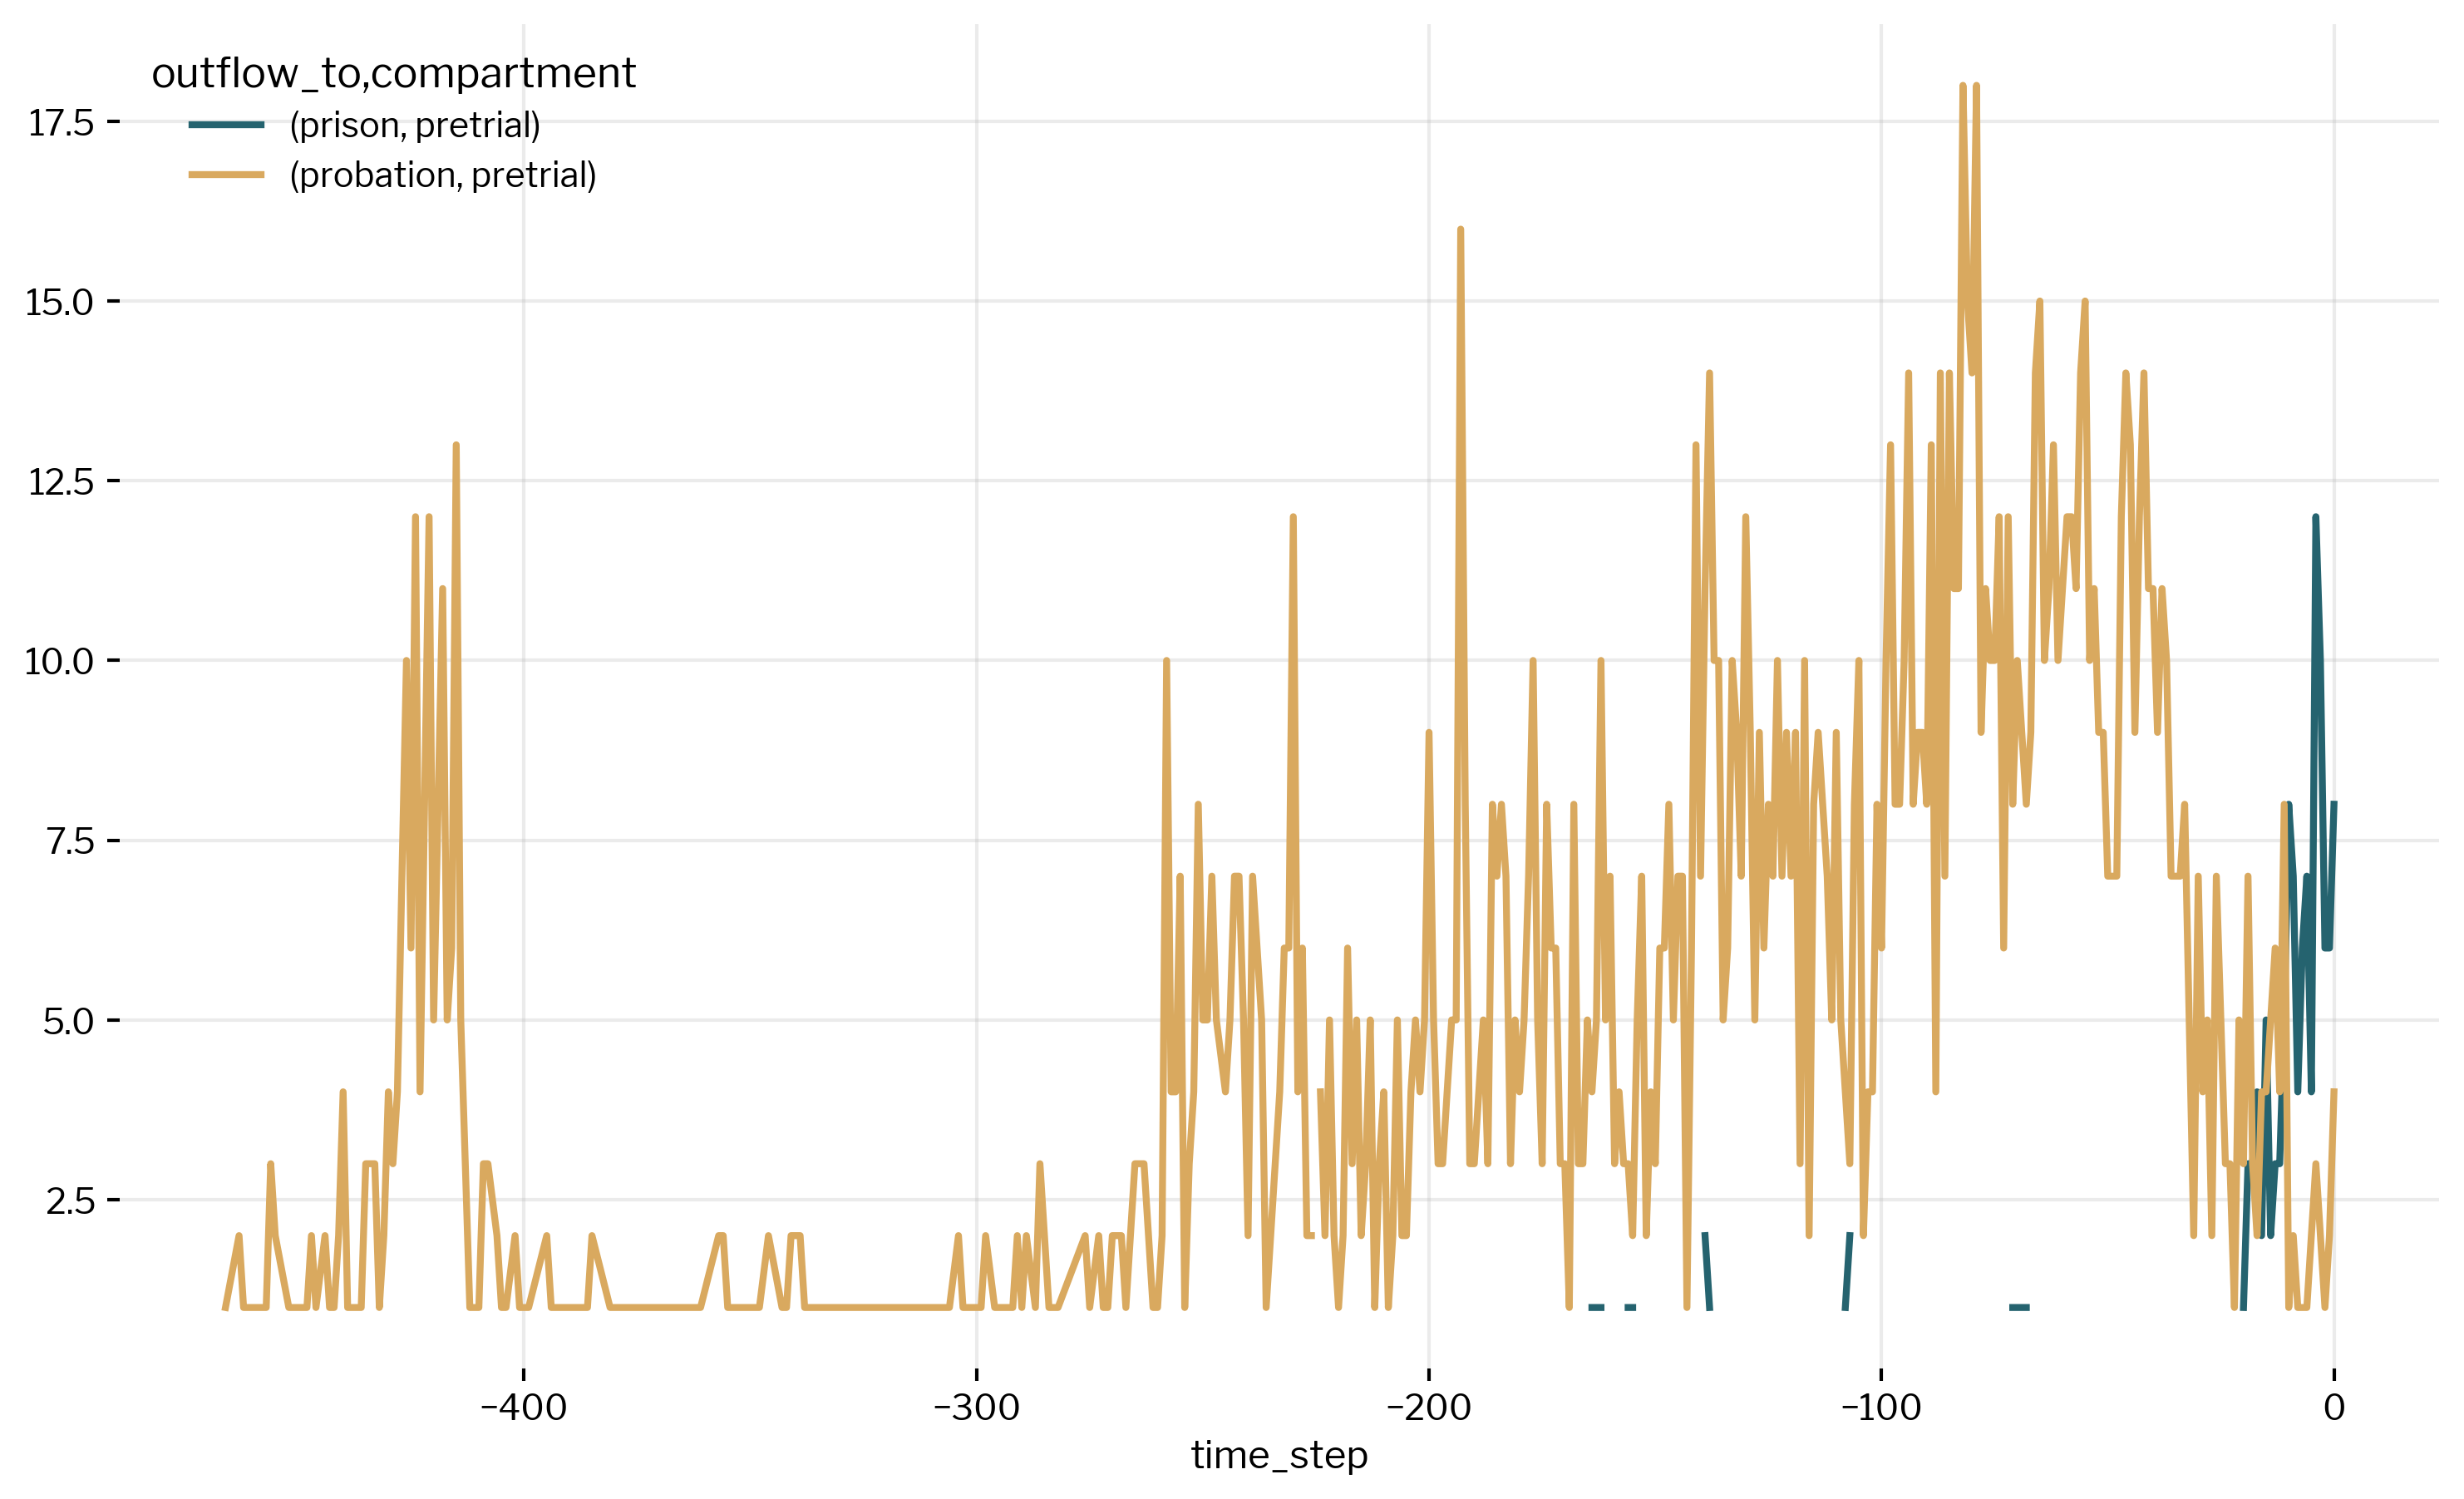

In [573]:
monthly_admissions_data.pivot(
    index="time_step",
    columns=["outflow_to", "compartment"],
    values="total_population",
).plot()

In [574]:
monthly_admissions_data.head()

,outflow_to,time_step,total_population,compartment,crime_type
0,prison,-293,1.0,pretrial,none
1,prison,-225,1.0,pretrial,none
2,prison,-202,1.0,pretrial,none
3,prison,-200,1.0,pretrial,none
4,prison,-197,1.0,pretrial,none


In [575]:
simulation_tag

'nd_fentanyl_mm_2023_v1'

In [576]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=monthly_admissions_data,
    transitions_data_df=transitions,
    total_population_data_df=total_population,
    yaml_path=yaml_file_path,
)

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]
